# Flight Delay Prediction Models

## In this notebook, we will build and evaluate machine learning models to predict flight delays using PySpark.

# Import necessary libraries

In [31]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer, OneHotEncoder
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, RegressionEvaluator
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, r2_score, mean_absolute_error

# Create Spark session and load data

In [22]:
spark = SparkSession.builder.appName("FlightDelayPrediction").getOrCreate()

In [23]:
fact = spark.read.csv("../output/CleanFactFlight.csv", header=True, inferSchema=True)

In [24]:
dim_time = spark.read.csv("../output/Dim_Time.csv", header=True, inferSchema=True)
dim_date = spark.read.csv("../output/Dim_Date.csv", header=True, inferSchema=True)
dim_airport = spark.read.csv("../output/Dim_Airport.csv", header=True, inferSchema=True)
dim_marketing = spark.read.csv("../output/Dim_Marketing_Airline.csv", header=True, inferSchema=True)
dim_operating = spark.read.csv("../output/Dim_Operating_Airline.csv", header=True, inferSchema=True)

In [25]:
df = fact.select(
    "flight_id", "date_id", "departure_time_id", "origin_airport_id",
    "destination_airport_id", "marketing_airline_id", "operating_airline_id",
    "dep_delay_minutes", "crs_elapsed_time", "distance", "flight_complexity_score"
).filter(
    (col("dep_delay_minutes").isNotNull()) &
    (col("dep_delay_minutes") > -60) &
    (col("dep_delay_minutes") < 300)
)

df = df.join(
    dim_date.select("date_id", "year", "quarter", "month", "day_of_month", "week_of_year", "is_weekend"),
    on="date_id", how="left"
).withColumn("is_weekend_int", when((col("is_weekend") == True) | (col("is_weekend") == "true"), 1).otherwise(0))

df = df.join(
    dim_time.select(
        col("time_id").alias("dep_tid"),
        col("hour").alias("dep_hour"),
        col("minute").alias("dep_minute"),
        col("period_of_day").alias("dep_period_of_day")
    ),
    df.departure_time_id == col("dep_tid"), how="left"
)
df = df.join(
    dim_airport.select(
        col("airport_id").alias("origin_id"),
        col("airport_code").alias("origin_airport_code"),
        col("state_name").alias("origin_state"),
        col("country").alias("origin_country")
    ),
    df.origin_airport_id == col("origin_id"), how="left"
)

df = df.join(
    dim_airport.select(
        col("airport_id").alias("dest_id"),
        col("airport_code").alias("dest_airport_code"),
        col("state_name").alias("dest_state"),
        col("country").alias("dest_country")
    ),
    df.destination_airport_id == col("dest_id"), how="left"
)
df = df.join(
    dim_marketing.select(
        col("marketing_airline_id").alias("mkt_id"),
        col("iata_code").alias("marketing_iata")
    ),
    df.marketing_airline_id == col("mkt_id"), how="left"
)
df = df.join(
    dim_operating.select(
        col("operating_airline_id").alias("op_id"),
        col("iata_code").alias("operating_iata")
    ),
    df.operating_airline_id == col("op_id"), how="left"
)
df = df.withColumn("delay_flag", when(col("dep_delay_minutes") > 15, 1).otherwise(0))

# MLP Classifier for Delay Prediction

In [26]:
cat_cols = ["origin_state", "dest_state", "marketing_iata", "operating_iata", "dep_period_of_day"]
num_cols = ["distance", "crs_elapsed_time", "flight_complexity_score", "dep_hour", "dep_minute",
            "month", "day_of_month", "week_of_year", "is_weekend_int"]

indexers = [StringIndexer(inputCol=c, outputCol=f"{c}_idx", handleInvalid="keep") for c in cat_cols]
encoders = [OneHotEncoder(inputCol=f"{c}_idx", outputCol=f"{c}_vec") for c in cat_cols]
assembler = VectorAssembler(inputCols=[f"{c}_vec" for c in cat_cols] + num_cols, outputCol="features_vec")
scaler = StandardScaler(inputCol="features_vec", outputCol="features")


MLP Classifier Metrics Summary:
   Dataset  Accuracy  Precision  Recall  F1 Score
     Train     0.997      0.996   0.991     0.994
Validation     0.997      0.995   0.991     0.993
      Test     0.997      0.995   0.990     0.993


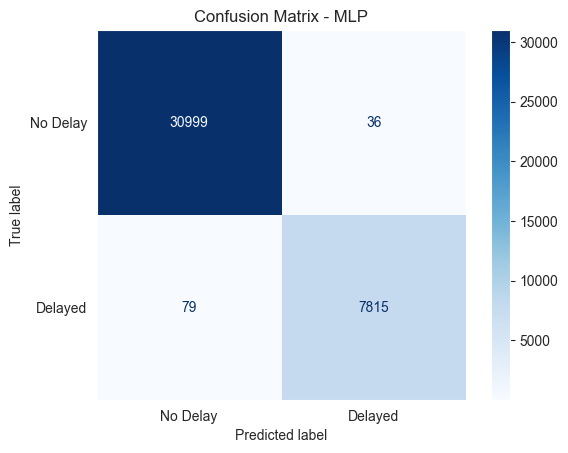

In [32]:
tmp_pipeline = Pipeline(stages=indexers + encoders + [assembler])
tmp_model = tmp_pipeline.fit(df)
tmp_df = tmp_model.transform(df)
sample = tmp_df.select("features_vec").limit(1).collect()
num_features = len(sample[0][0])

mlp_layers = [num_features, 12, 6, 2]
mlp = MultilayerPerceptronClassifier(
    featuresCol="features", labelCol="delay_flag", predictionCol="prediction",
    maxIter=100, layers=mlp_layers, blockSize=128, seed=42
)
pipeline_cls = Pipeline(stages=indexers + encoders + [assembler, scaler, mlp])

train_cls, val_cls, test_cls = df.randomSplit([0.7, 0.15, 0.15], seed=42)
model_cls = pipeline_cls.fit(train_cls)
cls_eval = MulticlassClassificationEvaluator(labelCol="delay_flag", predictionCol="prediction")

# TRAIN
pred_train_cls = model_cls.transform(train_cls)
train_pd = pred_train_cls.select("delay_flag", "prediction").dropna().toPandas()
train_acc = cls_eval.evaluate(pred_train_cls, {cls_eval.metricName: "accuracy"})
train_prec = precision_score(train_pd["delay_flag"], train_pd["prediction"])
train_rec = recall_score(train_pd["delay_flag"], train_pd["prediction"])
train_f1 = f1_score(train_pd["delay_flag"], train_pd["prediction"])

# VALIDATION
pred_val_cls = model_cls.transform(val_cls)
val_pd = pred_val_cls.select("delay_flag", "prediction").dropna().toPandas()
val_acc = cls_eval.evaluate(pred_val_cls, {cls_eval.metricName: "accuracy"})
val_prec = precision_score(val_pd["delay_flag"], val_pd["prediction"])
val_rec = recall_score(val_pd["delay_flag"], val_pd["prediction"])
val_f1 = f1_score(val_pd["delay_flag"], val_pd["prediction"])

# TEST
pred_cls = model_cls.transform(test_cls)
pred_pd = pred_cls.select("delay_flag", "prediction").dropna().toPandas()
acc = cls_eval.evaluate(pred_cls, {cls_eval.metricName: "accuracy"})
prec = precision_score(pred_pd["delay_flag"], pred_pd["prediction"])
rec = recall_score(pred_pd["delay_flag"], pred_pd["prediction"])
f1 = f1_score(pred_pd["delay_flag"], pred_pd["prediction"])

metrics_df = pd.DataFrame({
    "Dataset": ["Train", "Validation", "Test"],
    "Accuracy": [train_acc, val_acc, acc],
    "Precision": [train_prec, val_prec, prec],
    "Recall": [train_rec, val_rec, rec],
    "F1 Score": [train_f1, val_f1, f1]
})

print("\nMLP Classifier Metrics Summary:")
print(metrics_df.round(3).to_string(index=False))

cm = confusion_matrix(pred_pd["delay_flag"], pred_pd["prediction"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Delay", "Delayed"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - MLP")
plt.grid(False)
plt.show()


# GBT Regressor for Delay Prediction

   Dataset  RMSE   MAE    R2
     Train 5.846 1.788 0.967
Validation 6.129 1.848 0.964
      Test 5.895 1.776 0.966


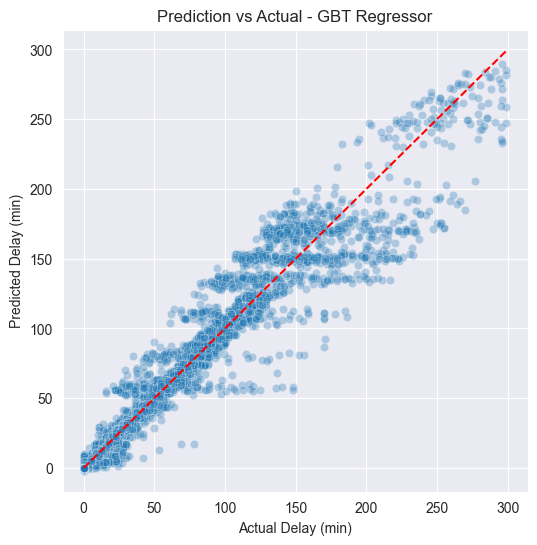

In [33]:
gbt = GBTRegressor(featuresCol="features", labelCol="dep_delay_minutes",
                   predictionCol="prediction", maxIter=50)
pipeline_reg = Pipeline(stages=indexers + encoders + [assembler, scaler, gbt])

train_reg, val_reg, test_reg = df.randomSplit([0.7, 0.15, 0.15], seed=42)
model_reg = pipeline_reg.fit(train_reg)
reg_eval = RegressionEvaluator(labelCol="dep_delay_minutes", predictionCol="prediction")

pred_train_reg = model_reg.transform(train_reg)
train_pd = pred_train_reg.select("dep_delay_minutes", "prediction").dropna().toPandas()
train_rmse = reg_eval.evaluate(pred_train_reg, {reg_eval.metricName: "rmse"})
train_mae = mean_absolute_error(train_pd["dep_delay_minutes"], train_pd["prediction"])
train_r2 = r2_score(train_pd["dep_delay_minutes"], train_pd["prediction"])

pred_val_reg = model_reg.transform(val_reg)
val_pd = pred_val_reg.select("dep_delay_minutes", "prediction").dropna().toPandas()
val_rmse = reg_eval.evaluate(pred_val_reg, {reg_eval.metricName: "rmse"})
val_mae = mean_absolute_error(val_pd["dep_delay_minutes"], val_pd["prediction"])
val_r2 = r2_score(val_pd["dep_delay_minutes"], val_pd["prediction"])

pred_reg = model_reg.transform(test_reg)
pred_reg_pd = pred_reg.select("dep_delay_minutes", "prediction").dropna().toPandas()
rmse = reg_eval.evaluate(pred_reg, {reg_eval.metricName: "rmse"})
mae = mean_absolute_error(pred_reg_pd["dep_delay_minutes"], pred_reg_pd["prediction"])
r2 = r2_score(pred_reg_pd["dep_delay_minutes"], pred_reg_pd["prediction"])

metrics_reg = pd.DataFrame({
    "Dataset": ["Train", "Validation", "Test"],
    "RMSE": [train_rmse, val_rmse, rmse],
    "MAE": [train_mae, val_mae, mae],
    "R2": [train_r2, val_r2, r2]
})
print(metrics_reg.round(3).to_string(index=False))

plt.figure(figsize=(6, 6))
sns.scatterplot(x="dep_delay_minutes", y="prediction", data=pred_reg_pd, alpha=0.3)
plt.xlabel("Actual Delay (min)")
plt.ylabel("Predicted Delay (min)")
plt.title("Prediction vs Actual - GBT Regressor")
plt.plot([0, pred_reg_pd["dep_delay_minutes"].max()],
         [0, pred_reg_pd["dep_delay_minutes"].max()], 'r--')
plt.grid(True)
plt.show()

# Conclusion
The results demonstrate that both models performed exceptionally well on the flight delay prediction task.
The Multilayer Perceptron (MLP) Classifier achieved almost perfect classification metrics, with accuracy, precision, recall, and F1 score all around 99.7% across the training, validation, and test datasets.
The confusion matrix confirms that the model correctly identified nearly all delayed and non-delayed flights, with only a few misclassifications.
This suggests that the feature set effectively captures the relationships that determine whether a flight will be delayed.

The Gradient Boosted Trees (GBT) Regressor also showed strong predictive performance, with RMSE values around 5.8–6.1 minutes, MAE around 1.8 minutes, and R² above 0.96 across all data splits.
The scatter plot of predicted versus actual delays shows a near-linear pattern along the diagonal, indicating a close alignment between model predictions and true delay durations, with minimal deviation.

Overall, both models exhibit excellent generalization and stability, suggesting that the data preprocessing, feature engineering, and model configurations were highly effective.
The MLP classifier is well-suited for real-time delay detection, while the GBT regressor can provide accurate delay duration estimates.
Further work could explore more complex temporal patterns, ensemble methods, or explainability analysis to better understand the factors influencing flight delays.